<a href="https://colab.research.google.com/github/Zalring/ZStable-Diffusion/blob/main/ZStable_Diffusion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Stable Diffusion text-to-image and image-to-image synthesis

--

**NB: As this Colab doesn't rely on Huggingface, for now you'll have to manually [download the model](https://huggingface.co/CompVis/stable-diffusion-v-1-4-original) and then upload it to *'MyDrive/AI/ZStable_Diffusion/models/sd-v1-4.ckpt'* in order to use it.**

--

#### From the [Stable Diffusion](https://github.com/CompVis/stable-diffusion) repo :

- Stable Diffusion is a latent text-to-image diffusion model. Thanks to a generous compute donation from Stability AI and support from LAION, we were able to train a Latent Diffusion Model on 512x512 images from a subset of the LAION-5B database. Similar to Google's Imagen, this model uses a frozen CLIP ViT-L/14 text encoder to condition the model on text prompts. With its 860M UNet and 123M text encoder, the model is relatively lightweight and runs on a GPU with at least 10GB VRAM. See this section below and the model card.
- Stable Diffusion v1 refers to a specific configuration of the model architecture that uses a downsampling-factor 8 autoencoder with an 860M UNet and CLIP ViT-L/14 text encoder for the diffusion model. The model was pretrained on 256x256 images and then finetuned on 512x512 images.
- By using a diffusion-denoising mechanism as first proposed by SDEdit, the model can be used for different tasks such as text-guided image-to-image translation and upscaling. Similar to the txt2img sampling script, we provide a script to perform image modification with Stable Diffusion.

--

Special features of this Colab :
- Settings saving
- Better image save management
- Multi-prompts (1 per iteration)
- Make easier to use your txt2img/img2img outputs as img2img inputs (multiple inputs for img2img possible)
- [Real-ESRGAN](https://github.com/xinntao/Real-ESRGAN) upscaling and face enhancement
- No NSFW filter.

--

Colab assembled by [Zalring](https://twitter.com/ZalringTW).

##Check GPU

In [1]:
!nvidia-smi

Tue Aug 23 23:01:25 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Setup options

In [2]:
#@markdown Enable saving outputs to Google Drive to save your creations at AI/models
save_outputs_to_google_drive = True #@param {type:"boolean"}
#@markdown Enable saving models to Google Drive to avoid downloading the model every Colab instance
save_models_to_google_drive = True #@param {type:"boolean"}
#@markdown Enable the load of an upscaler
load_upscaler = True #@param {type:"boolean"}

# Setup

## Utils

In [3]:
import subprocess, os, sys, ipykernel, shutil

def gitclone(url):
  res = subprocess.run(['git', 'clone', url], stdout=subprocess.PIPE).stdout.decode('utf-8')
  print(res)

def pipi(modulestr):
  res = subprocess.run(['pip', 'install', modulestr], stdout=subprocess.PIPE).stdout.decode('utf-8')
  print(res)

def pipir(txtfile):
  res = subprocess.run(['pip', 'install', 'r', txtfile], stdout=subprocess.PIPE).stdout.decode('utf-8')
  print(res)

def pipie(modulestr):
  res = subprocess.run(['git', 'install', '-e', modulestr], stdout=subprocess.PIPE).stdout.decode('utf-8')
  print(res)

def wget(url, outputdir):
  res = subprocess.run(['wget', url, '-P', f'{outputdir}'], stdout=subprocess.PIPE).stdout.decode('utf-8')
  print(res)

def createPath(filepath):
  os.makedirs(filepath, exist_ok=True)

##Save model and outputs on Google Drive if available

In [4]:

if save_outputs_to_google_drive or save_models_to_google_drive:
  try : # Colab
      from google.colab import drive
      use_colab = True
      try:
        drive.mount('/content/drive')
        root_path = "/content/drive/MyDrive/AI/ZStable_Diffusion"
      except:
        print("Google Colab not detected.")
        #save_outputs_to_google_drive = False
        #save_models_to_google_drive = False
        root_path = "/content"
  except : # Local
    root_path = os.getcwd()
    # If running locally, there's a good chance your env will need this in order to not crash upon np.matmul() or similar operations.
    os.environ['KMP_DUPLICATE_LIB_OK']='TRUE'
    use_colab = False

model_path = f'{root_path}/models'
outputs_path = f'{root_path}/images_out'

createPath(model_path) #!mkdir -p $model_path
createPath(outputs_path)#!mkdir -p $outputs_path

print(f"Model will be stored at {model_path}")
print(f"Outputs will be saved to {outputs_path}")


Mounted at /content/drive
Model will be stored at /content/drive/MyDrive/AI/ZStable_Diffusion/models
Outputs will be saved to /content/drive/MyDrive/AI/ZStable_Diffusion/images_out


## Download code and model

In [5]:
# Stable Diffusion

sys.path.append(".")

gitclone("https://github.com/CompVis/taming-transformers")
pipie("./taming-transformers")
sys.path.append('./taming-transformers')

pipi("omegaconf>=2.0.0")
pipi("pytorch-lightning>=1.0.8")
pipi("einops")
pipi("transformers")
pipi("kornia")
pipi("ftfy")

gitclone("https://github.com/openai/CLIP.git")
pipie("./CLIP")
sys.path.append('./CLIP')

gitclone("https://github.com/CompVis/stable-diffusion.git")
sys.path.append('./stable-diffusion')



Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for antlr4-python3-runtime: filename=antlr4_python3_runtime-4.9.3-py3-none-any.whl size=144575 sha256=3f7d3c041782ad0e20d04b291ffdda6d99a77b8f5dc3b1a555768000d4c0878f
  Stored in directory: /root/.cache/pip/wheels/8b/8d/53/2af8772d9aec614e3fc65e53d4a993ad73c61daa8bbd85a873
Successfully built antlr4-python3-runtime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.8.0
    Uninstalling tensorboard-2.8.0:
      Successfully uninstalled tensorboard-2.8.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/sim

In [6]:
# Real-ESRGAN
if load_upscaler:
  gitclone("https://github.com/xinntao/Real-ESRGAN.git")
  #sys.path.append('./Real-ESRGAN')

  %cd /content/Real-ESRGAN

  pipi("basicsr")
  pipi("facexlib")
  pipi("gfpgan")
  pipir("./Real-ESRGAN/requirements.txt")

  !python setup.py develop
  %cd /content



/content/Real-ESRGAN
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for basicsr: filename=basicsr-1.4.1-py3-none-any.whl size=213765 sha256=5fcc32cf6dfe3a88b451386725dd2935fdd19e951fc59992346c84dcaa5ae73e
  Stored in directory: /root/.cache/pip/wheels/36/c5/b3/dc9fdd1dc0f95e37ef35144686bfa374cb81985a38a8539ba0
Successfully built basicsr

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for filterpy: filename=filterpy-1.4.5-py3-none-any.whl size=110474 sha256=8c269c71d324a2903565d7d2197eb4167583ee2b6ff47464c5edf1751bcb8cbc
  Stored in directory: /root/.cache/pip/wheels/ce/e0/ee/a2b3c5caab3418c1ccd8c4de573d4cbe13315d7e8b0a55fbc2
Successfully built filterpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.6
    Uninstalling numpy-1.2

###Download the models

In [7]:
# SD
if os.path.isfile(f"{model_path}/sd-v1-4.ckpt"):
    print("Stable diffusion: Using saved model from Google Drive")
else:
    print("For now, you need to provide your own source for the model.")
    #wget("IDK !", model_path)

Stable diffusion: Using saved model from Google Drive


In [8]:
# Real-ESRGAN
if load_upscaler: 
  if os.path.isfile(f"{model_path}/RealESRGAN_x4plus.pth"):
      print("Real-ESRGAN: Using saved model from Google Drive")
  else:
      wget('https://github.com/xinntao/Real-ESRGAN/releases/download/v0.1.0/RealESRGAN_x4plus.pth', model_path)
      #!wget https://github.com/xinntao/Real-ESRGAN/releases/download/v0.1.0/RealESRGAN_x4plus.pth -P experiments/pretrained_models

  if os.path.isfile(f"{model_path}/detection_Resnet50_Final.pth"):
      print("Real-ESRGAN: Using saved model from Google Drive")
  else:
      wget('https://github.com/xinntao/facexlib/releases/download/v0.1.0/detection_Resnet50_Final.pth', model_path)

  if os.path.isfile(f"{model_path}/parsing_parsenet.pth"):
      print("Real-ESRGAN: Using saved model from Google Drive")
  else:
      wget('https://github.com/xinntao/facexlib/releases/download/v0.2.2/parsing_parsenet.pth', model_path)

  if os.path.isfile(f"{model_path}/GFPGANv1.3.pth"):
      print("Real-ESRGAN: Using saved model from Google Drive")
  else:
      wget('https://github.com/TencentARC/GFPGAN/releases/download/v1.3.0/GFPGANv1.3.pth', model_path)

  shutil.copy(f"{model_path}/RealESRGAN_x4plus.pth", './Real-ESRGAN/experiments/pretrained_models/RealESRGAN_x4plus.pth')

  shutil.copy(f"{model_path}/detection_Resnet50_Final.pth", '/usr/local/lib/python3.7/dist-packages/gfpgan/weights/detection_Resnet50_Final.pth')
  shutil.copy(f"{model_path}/parsing_parsenet.pth", '/usr/local/lib/python3.7/dist-packages/gfpgan/weights/parsing_parsenet.pth')
  shutil.copy(f"{model_path}/GFPGANv1.3.pth", '/usr/local/lib/python3.7/dist-packages/gfpgan/weights/GFPGANv1.3.pth')

Real-ESRGAN: Using saved model from Google Drive
Real-ESRGAN: Using saved model from Google Drive
Real-ESRGAN: Using saved model from Google Drive
Real-ESRGAN: Using saved model from Google Drive


## Imports

In [9]:
import argparse, os, sys, glob
from taming.models import vqgan
import torch
import numpy as np
from omegaconf import OmegaConf
import PIL
from PIL import Image
from tqdm import tqdm, trange
from itertools import islice
from einops import rearrange, repeat
from torchvision.utils import make_grid
import time
from pytorch_lightning import seed_everything
from torch import autocast
from contextlib import contextmanager, nullcontext

import gc

#%cd /content/stable-diffusion
from ldm.util import instantiate_from_config
from ldm.models.diffusion.ddim import DDIMSampler
from ldm.models.diffusion.plms import PLMSSampler
#%cd /content

## Functions and model loading

### Load SD functions

In [10]:
#%cd /content/stable-diffusion

def reach(li, to_n):
    if len(li)==0:
        return li
    return (li + ([li[-1]] * max(0, to_n-len(li))))[:to_n]

def chunk(it, size):
    it = iter(it)
    return iter(lambda: tuple(islice(it, size)), ())


def load_model_from_config(config, ckpt, verbose=False):
    print(f"Loading model from {ckpt}")
    pl_sd = torch.load(ckpt, map_location="cpu")
    if "global_step" in pl_sd:
        print(f"Global Step: {pl_sd['global_step']}")
    sd = pl_sd["state_dict"]
    model = instantiate_from_config(config.model)
    m, u = model.load_state_dict(sd, strict=False)
    if len(m) > 0 and verbose:
        print("missing keys:")
        print(m)
    if len(u) > 0 and verbose:
        print("unexpected keys:")
        print(u)

    model.cuda()
    model.eval()
    return model

def txt2img(opt):
    """
    opt :
      prompt (str) : the prompt to render
      outdir (str) : dir to write results to
      skip_grid (bool) : do not save a grid, only individual samples. Helpful when evaluating lots of samples
      skip_save (bool) : do not save individual samples. For speed measurements
      ddim_steps (int, default=50) : number of ddim sampling steps
      plms (bool) : use plms sampling instead of ddim
      #   laion400m (bool) : uses the LAION400M model
      fixed_code (bool) : if enabled, uses the same starting code across samples
      ddim_eta (float, default=0.0) : ddim eta (eta=0.0 corresponds to deterministic sampling)
      n_iter (int, default=2) : sample this often
      H (int, default=512) : image height, in pixel space
      W (int, default=512) : image width, in pixel space
      C (int, default=4) : latent channels
      f (int, default=8) : downsampling factor
      n_samples (int, default=3) : how many samples to produce for each given prompt. A.k.a. batch size
      n_rows (int, default=0) : rows in the grid (default: n_samples)
      scale (float, default=7.5) : unconditional guidance scale: eps = eps(x, empty) + scale * (eps(x, cond) - eps(x, empty))
      #   from_file (str) : if specified, load prompts from this file
      #   config (str, default="configs/stable-diffusion/v1-inference.yaml") : path to config which constructs model
      #   ckpt (str, default="models/ldm/stable-diffusion-v1/model.ckpt") : path to checkpoint of model
      seed (int) : the seed (for reproducible sampling)
      precision (str, choices=["full", "autocast"], default="autocast") : evaluate at this precision
    """

    #if opt.laion400m:
    #    print("Falling back to LAION 400M model...")
    #    opt.config = "configs/latent-diffusion/txt2img-1p4B-eval.yaml"
    #    opt.ckpt = "models/ldm/text2img-large/model.ckpt"
    #    opt.outdir = "outputs/txt2img-samples-laion400m"

    torch.cuda.empty_cache()
    gc.collect()

    seed_everything(opt.seed)

    if opt.plms:
        sampler = PLMSSampler(model)
    else:
        sampler = DDIMSampler(model)

    os.makedirs(opt.outdir, exist_ok=True)
    outpath = opt.outdir

    batch_size = opt.n_samples
    n_rows = opt.n_rows if opt.n_rows > 0 else batch_size

    sample_path = os.path.join(outpath, "samples")
    os.makedirs(sample_path, exist_ok=True)
    grid_count = len(os.listdir(outpath)) - 1

    base_count = 0
    for d in glob.glob(sample_path+"/*"):
        try :
            bname = int(os.path.basename(d)[:-4])
            if bname >= base_count:
                base_count = bname+1
        except : pass
    #base_count = len(os.listdir(sample_path))
    bbase_count = base_count


    start_code = None
    if opt.fixed_code:
        start_code = torch.randn([opt.n_samples, opt.C, opt.H // opt.f, opt.W // opt.f], device=device)

    precision_scope = autocast if opt.precision=="autocast" else nullcontext
    with torch.no_grad():
        with precision_scope("cuda"):
            with model.ema_scope():
                tic = time.time()
                all_samples = list()
                for n in trange(opt.n_iter, desc="Sampling"):

                    if True or not opt.from_file:
                        prompt = opt.prompt
                        assert prompt is not None
                        data = [batch_size * [prompt[n]]]
                    #else:
                    #    print(f"reading prompts from {opt.from_file}")
                    #    with open(opt.from_file, "r") as f:
                    #        data = f.read().splitlines()
                    #        data = list(chunk(data, batch_size))

                    for prompts in tqdm(data, desc="data"):
                        uc = None
                        if opt.scale != 1.0:
                            uc = model.get_learned_conditioning(batch_size * [""])
                        if isinstance(prompts, tuple):
                            prompts = list(prompts)
                        c = model.get_learned_conditioning(prompts)
                        shape = [opt.C, opt.H // opt.f, opt.W // opt.f]
                        samples_ddim, _ = sampler.sample(S=opt.ddim_steps,
                                                         conditioning=c,
                                                         batch_size=opt.n_samples,
                                                         shape=shape,
                                                         verbose=False,
                                                         unconditional_guidance_scale=opt.scale,
                                                         unconditional_conditioning=uc,
                                                         eta=opt.ddim_eta,
                                                         x_T=start_code)

                        x_samples_ddim = model.decode_first_stage(samples_ddim)
                        x_samples_ddim = torch.clamp((x_samples_ddim + 1.0) / 2.0, min=0.0, max=1.0)

                        if not opt.skip_save:
                            for x_sample in x_samples_ddim:
                                x_sample = 255. * rearrange(x_sample.cpu().numpy(), 'c h w -> h w c')
                                Image.fromarray(x_sample.astype(np.uint8)).save(
                                    os.path.join(sample_path, f"{base_count}.png"))
                                base_count += 1

                        if not opt.skip_grid:
                            all_samples.append(x_samples_ddim)

                if not opt.skip_grid:
                    # additionally, save as grid
                    grid = torch.stack(all_samples, 0)
                    grid = rearrange(grid, 'n b c h w -> (n b) c h w')
                    grid = make_grid(grid, nrow=n_rows)

                    # to image
                    grid = 255. * rearrange(grid, 'c h w -> h w c').cpu().numpy()
                    gimg = Image.fromarray(grid.astype(np.uint8))
                    gimg.save(os.path.join(outpath, f'grid-{grid_count:04}.png'))
                    grid_count += 1

                    display(gimg) # TMP

                toc = time.time()

    print(f"Your samples are ready and waiting for you here: \n{outpath} \n"
          f" \nEnjoy.")
    
    return bbase_count

def load_img(path, w, h):
    image = Image.open(path).convert("RGB")
    #w, h = image.size
    print(f"loaded input image of size ({w}, {h}) from {path}")
    w, h = map(lambda x: x - x % 32, (w, h))  # resize to integer multiple of 32
    image = image.resize((w, h), resample=PIL.Image.LANCZOS)
    image = np.array(image).astype(np.float32) / 255.0
    image = image[None].transpose(0, 3, 1, 2)
    image = torch.from_numpy(image)
    return 2.*image - 1.

def img2img(opt):

    torch.cuda.empty_cache()
    gc.collect()

    seed_everything(opt.seed)

    if opt.plms:
        raise NotImplementedError("PLMS sampler not (yet) supported")
        sampler = PLMSSampler(model)
    else:
        sampler = DDIMSampler(model)

    os.makedirs(opt.outdir, exist_ok=True)
    outpath = opt.outdir

    batch_size = opt.n_samples
    n_rows = opt.n_rows if opt.n_rows > 0 else batch_size

    sample_path = os.path.join(outpath, "samples")
    os.makedirs(sample_path, exist_ok=True)
    grid_count = len(os.listdir(outpath)) - 1

    base_count = 0
    for d in glob.glob(sample_path+"/*"):
        try :
            bname = int(os.path.basename(d)[:-4])
            if bname >= base_count:
                base_count = bname+1
        except : pass
    #base_count = len(os.listdir(sample_path))
    bbase_count = base_count

    init_latent = []
    for n in range(opt.n_iter) :
        assert os.path.isfile(opt.init_img[n])
        init_image = load_img(opt.init_img[n], opt.W, opt.H).to(device)
        init_image = repeat(init_image, '1 ... -> b ...', b=batch_size)
        init_latent.append(model.get_first_stage_encoding(model.encode_first_stage(init_image)))  # move to latent space

    sampler.make_schedule(ddim_num_steps=opt.ddim_steps, ddim_eta=opt.ddim_eta, verbose=False)

    assert 0. <= opt.strength <= 1., 'can only work with strength in [0.0, 1.0]'
    t_enc = int(opt.strength * opt.ddim_steps)
    print(f"target t_enc is {t_enc} steps")

    precision_scope = autocast if opt.precision == "autocast" else nullcontext
    with torch.no_grad():
        with precision_scope("cuda"):
            with model.ema_scope():
                tic = time.time()
                all_samples = list()
                for n in trange(opt.n_iter, desc="Sampling"):

                    if True or not opt.from_file:
                        prompt = opt.prompt
                        assert prompt is not None
                        data = [batch_size * [prompt[n]]]
                    #else:
                    #    print(f"reading prompts from {opt.from_file}")
                    #    with open(opt.from_file, "r") as f:
                    #        data = f.read().splitlines()
                    #        data = list(chunk(data, batch_size))

                    for prompts in tqdm(data, desc="data"):
                        uc = None
                        if opt.scale != 1.0:
                            uc = model.get_learned_conditioning(batch_size * [""])
                        if isinstance(prompts, tuple):
                            prompts = list(prompts)
                        c = model.get_learned_conditioning(prompts)

                        # encode (scaled latent)
                        z_enc = sampler.stochastic_encode(init_latent[n], torch.tensor([t_enc]*batch_size).to(device))
                        # decode it
                        samples = sampler.decode(z_enc, c, t_enc, unconditional_guidance_scale=opt.scale,
                                                 unconditional_conditioning=uc,)

                        x_samples = model.decode_first_stage(samples)
                        x_samples = torch.clamp((x_samples + 1.0) / 2.0, min=0.0, max=1.0)

                        if not opt.skip_save:
                            for x_sample in x_samples:
                                x_sample = 255. * rearrange(x_sample.cpu().numpy(), 'c h w -> h w c')
                                Image.fromarray(x_sample.astype(np.uint8)).save(
                                    os.path.join(sample_path, f"{base_count}.png"))
                                base_count += 1
                        all_samples.append(x_samples)

                if not opt.skip_grid:
                    # additionally, save as grid
                    grid = torch.stack(all_samples, 0)
                    grid = rearrange(grid, 'n b c h w -> (n b) c h w')
                    grid = make_grid(grid, nrow=n_rows)

                    # to image
                    grid = 255. * rearrange(grid, 'c h w -> h w c').cpu().numpy()
                    gimg = Image.fromarray(grid.astype(np.uint8))
                    gimg.save(os.path.join(outpath, f'grid-{grid_count:04}.png'))
                    grid_count += 1

                    display(gimg) # TMP

                toc = time.time()

    print(f"Your samples are ready and waiting for you here: \n{outpath} \n"
          f" \nEnjoy.")

    return bbase_count


#%cd /content

### Load Model

In [11]:
#%cd /content/stable-diffusion

config = OmegaConf.load("./stable-diffusion/configs/stable-diffusion/v1-inference.yaml")
model = load_model_from_config(config, f"{model_path}/sd-v1-4.ckpt")

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model = model.to(device)

#%cd /content

Loading model from /content/drive/MyDrive/AI/ZStable_Diffusion/models/sd-v1-4.ckpt
Global Step: 470000
LatentDiffusion: Running in eps-prediction mode
DiffusionWrapper has 859.52 M params.
making attention of type 'vanilla' with 512 in_channels
Working with z of shape (1, 4, 32, 32) = 4096 dimensions.
making attention of type 'vanilla' with 512 in_channels


Some weights of the model checkpoint at openai/clip-vit-large-patch14 were not used when initializing CLIPTextModel: ['vision_model.encoder.layers.22.layer_norm1.bias', 'vision_model.encoder.layers.0.self_attn.k_proj.weight', 'vision_model.encoder.layers.9.mlp.fc2.weight', 'vision_model.encoder.layers.18.self_attn.out_proj.bias', 'vision_model.encoder.layers.17.self_attn.k_proj.bias', 'vision_model.encoder.layers.22.self_attn.k_proj.bias', 'vision_model.encoder.layers.3.self_attn.k_proj.bias', 'vision_model.encoder.layers.22.self_attn.v_proj.weight', 'vision_model.encoder.layers.13.mlp.fc1.weight', 'vision_model.encoder.layers.6.mlp.fc1.weight', 'vision_model.encoder.layers.18.mlp.fc2.weight', 'vision_model.encoder.layers.10.self_attn.q_proj.weight', 'vision_model.encoder.layers.3.mlp.fc2.bias', 'vision_model.encoder.layers.3.mlp.fc1.weight', 'vision_model.encoder.layers.16.mlp.fc2.weight', 'vision_model.encoder.layers.12.self_attn.k_proj.bias', 'vision_model.encoder.layers.20.layer_no

### Load upscaler functions

In [12]:
if load_upscaler :
  def upscale(upload_folderr, filename, upscale_factor, downscale_factor, face_enhance):

    torch.cuda.empty_cache()
    gc.collect()

    %cd ./Real-ESRGAN

    upload_folder = './upload/'
    result_folder = './results/'

    if os.path.isdir(upload_folder):
        shutil.rmtree(upload_folder)
    if os.path.isdir(result_folder):
        shutil.rmtree(result_folder)
    os.mkdir(upload_folder)
    os.mkdir(result_folder)

    dst_path = os.path.join(upload_folder, filename)
    input_path = os.path.join(upload_folderr, filename)
    shutil.copy(input_path, dst_path)

    size = len(filename)

    def_upscale_factor = 1.0
    
    # if it is out of memory, try to use the `--tile` option
    if face_enhance :
      # more efficient if splited in two parts
      !python inference_realesrgan.py -n RealESRGAN_x4plus -i upload --outscale $def_upscale_factor --face_enhance
      os.remove(dst_path)
      shutil.move(f'{result_folder}{filename[:size - 4]}_out.png', dst_path)
      !python inference_realesrgan.py -n RealESRGAN_x4plus -i upload --outscale $upscale_factor
    else :
      !python inference_realesrgan.py -n RealESRGAN_x4plus -i upload --outscale $upscale_factor
    # Arguments
    # -n, --model_name: Model names
    # -i, --input: input folder or image
    # --outscale: Output scale, can be arbitrary scale factor.

    new_filename = f'{filename[:size - 4]}_out.png'
    new_new_filename = f'{filename[:size - 4]}_UPSCALED.png'
    computed_file_path = f'{result_folder}{new_filename}'
    destination_file_path = f'{upload_folderr}/{new_new_filename}'

    shutil.move(computed_file_path, destination_file_path)

    %cd ..

    image = Image.open(destination_file_path).convert("RGB")
    w, h = image.size
    w = int(w/downscale_factor)
    h = int(h/downscale_factor)
    image = image.resize((w, h), resample=PIL.Image.LANCZOS)
    image.save(destination_file_path)

    return new_new_filename


#Params tuto

- **prompt (list(str) or str) :** The prompt to render. It can be a list of prompts, each one being tied to one iteration.
- **init_img (list(str) or str or list(int) or int) :** **ONLY FOR img2img.** Path to the input image. It can be a list of paths, each image being tied to one iteration. NB: each image will be resized to HxW. If you type integer numbers instead of string paths, the process will use the corresponding generated images of the current folder (defined by **outdir**).

- **use_img2img (bool) :** Use an init image.
- **outdir (str) :** Directory to write results to.
- **skip_grid (bool) :** Do not save a grid, only individual samples. Helpful when evaluating lots of samples.
- **strength (float, default=0.75) :** **ONLY FOR img2img.** strength for noising/unnoising. 1.0 corresponds to full destruction of information in init image
- **ddim_steps (int, default=50) :** Number of DDIM sampling steps.
- **plms (bool) :** Use PLMS sampling instead of DDIM.
- **ddim_eta (float, default=0.0) :** DDIM eta (eta=0.0 corresponds to deterministic sampling).
- **n_iter (int, default=2) :** Sample this often.
- **n_samples (int, default=3) :** How many samples to produce for each given prompt. A.k.a. batch size.
- **H (int, default=512) :** Image height, in pixel space.
- **W (int, default=512) :** Image width, in pixel space.
- **f (int, default=8) :** Downsampling factor.
- **scale (float, default=7.5) :** Unconditional guidance scale: eps = eps(x, empty) + scale * (eps(x, cond) - eps(x, empty)).-
- **seed (int) :** The seed (for reproducible sampling). Random if set to -1.
- **precision (str, choices=\["full", "autocast"\], default="autocast") :** Evaluate at this precision.

# Prompts and init images

In [16]:

prompt = [
"Portrait of Margaret Thatcher as the Joker, cinematic lighting, highly detailed, digital painting, artstation, illustration, art by greg rutkowski and alphonse mucha"
]


In [14]:

init_img = [0, 1, 3] # ["./drive/MyDrive/XXX.png"]

# Run!

INFO:pytorch_lightning.utilities.seed:Global seed set to 2147266926
data:   0%|          | 0/1 [00:00<?, ?it/s]

Data shape for DDIM sampling is (3, 4, 64, 64), eta 0.5
Running DDIM Sampling with 50 timesteps




DDIM Sampler:   0%|          | 0/50 [00:00<?, ?it/s]

DDIM Sampler:   2%|▏         | 1/50 [00:00<00:46,  1.05it/s]

DDIM Sampler:   4%|▍         | 2/50 [00:01<00:45,  1.06it/s]

DDIM Sampler:   6%|▌         | 3/50 [00:02<00:44,  1.06it/s]

DDIM Sampler:   8%|▊         | 4/50 [00:03<00:43,  1.06it/s]

DDIM Sampler:  10%|█         | 5/50 [00:04<00:42,  1.06it/s]

DDIM Sampler:  12%|█▏        | 6/50 [00:05<00:41,  1.06it/s]

DDIM Sampler:  14%|█▍        | 7/50 [00:06<00:40,  1.06it/s]

DDIM Sampler:  16%|█▌        | 8/50 [00:07<00:39,  1.06it/s]

DDIM Sampler:  18%|█▊        | 9/50 [00:08<00:38,  1.06it/s]

DDIM Sampler:  20%|██        | 10/50 [00:09<00:37,  1.06it/s]

DDIM Sampler:  22%|██▏       | 11/50 [00:10<00:36,  1.06it/s]

DDIM Sampler:  24%|██▍       | 12/50 [00:11<00:35,  1.06it/s]

DDIM Sampler:  26%|██▌       | 13/50 [00:12<00:34,  1.06it/s]

DDIM Sampler:  28%|██▊       | 14/50 [00:13<00:33,  1.06it/s]

DDIM Sampler:  30%|███       | 15/50 [00:14<00:32,  1.06it/s]

DDIM Sam

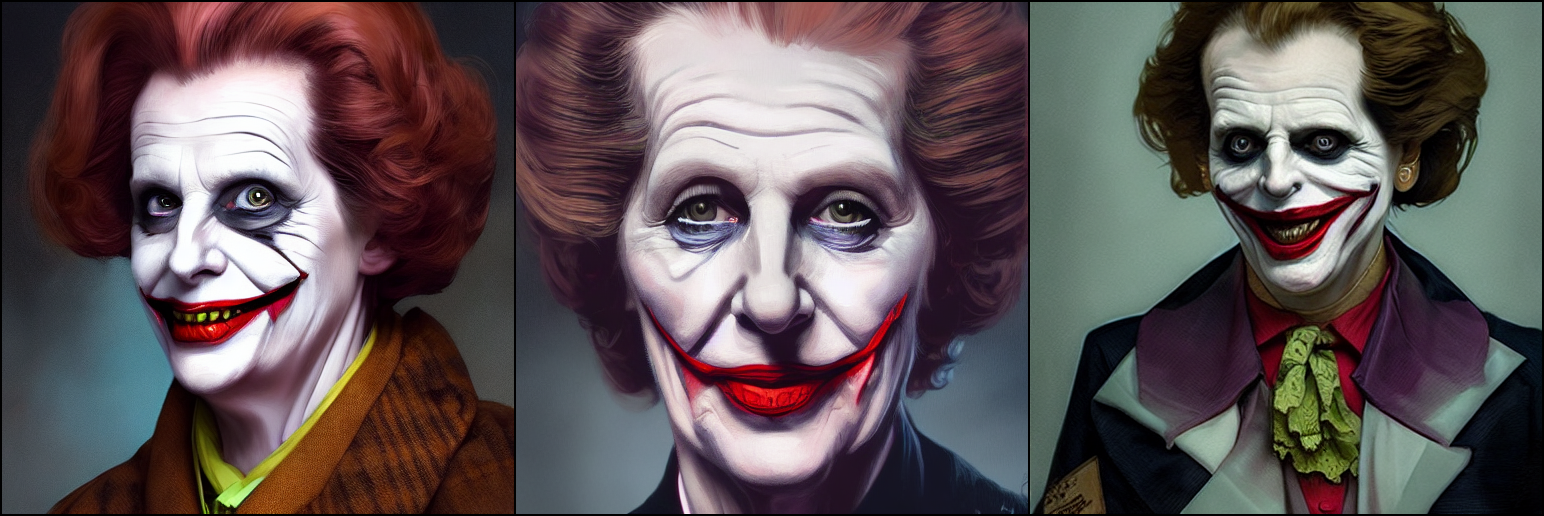

Your samples are ready and waiting for you here: 
/content/drive/MyDrive/AI/ZStable_Diffusion/images_out/TimeToStableDiff 
 
Enjoy.
Seed: 2147266926
Images index: [300, 301, 302]


In [18]:
#@title Parameters

import random as rd
import json

use_img2img = False #@param {type:"boolean"}
outdir = "TimeToStableDiff" #@param{type:"string"}
skip_grid = False #@param {type:"boolean"}
#skip_save = False #@param {type:"boolean"}
strength = 0.5 #@param {type:"number"}
ddim_steps = 50 #@param{type:"integer"}
plms = False #@param {type:"boolean"}
#fixed_code = False #@param {type:"boolean"}
ddim_eta = 0.5 #@param {type:"number"}
n_iter = 1 #@param{type:"integer"}
n_samples = 3 #@param{type:"integer"}
H = 512 #@param{type:"integer"}
W = 512 #@param{type:"integer"}
f = 8 #@param{type:"integer"}
scale = 7.5 #@param {type:"number"}
seed = -1 #@param{type:"integer"}
precision = "autocast" #@param ["autocast", "full"] {type:"string"}

abs_outdir = f'{outputs_path}/{outdir}'
createPath(abs_outdir)
true_seed = (rd.randint(0, (2**32)-1) if (seed==-1) else seed)

if not isinstance(prompt, list) : prompt = [prompt]
prompt = reach(prompt, n_iter)

if not isinstance(init_img, list) : init_img = [init_img]
init_img = reach(init_img, n_iter)

abs_init_img = []
for p in init_img :
  if isinstance(p, int) :
    abs_init_img.append(f"{abs_outdir}/samples/{p}.png")
  else : abs_init_img.append(p)

args = argparse.Namespace(
  prompt = prompt,
  init_img = abs_init_img,
  outdir = abs_outdir,
  skip_grid = skip_grid,
  skip_save = False,
  strength = strength,
  ddim_steps = ddim_steps,
  plms = plms,
  fixed_code = False,
  ddim_eta = ddim_eta,
  n_iter = n_iter,
  H = H,
  W = W,
  C = 4,
  f = f,
  n_samples = n_samples,
  n_rows = 0,
  scale = scale,
  from_file = False,
  seed = true_seed,
  precision = precision
)

first_idx_img = img2img(args) if use_img2img else txt2img(args)
print(f'Seed: {true_seed}')
print(f'Images index: {list(range(first_idx_img, first_idx_img+n_samples*n_iter))}')

settings_fname = f'{abs_outdir}/samples/{first_idx_img}-{-1+first_idx_img+n_samples*n_iter}_settings.txt'

#save settings
with open(settings_fname, 'w+') as f:
    json.dump(vars(args), f, ensure_ascii=False, indent=4)

# Run upscaler

In [ ]:
upscale_factor = 4.0 #@param{type: "number"}
downscale_factor = 1.0 #@param{type: "number"}
upscale_enhance_faces = False #@param{type: "boolean"}
results_idx = [] #@param{type: "raw"}
#@markdown `results_idx` must contain the list of the results (in the `outdir` folder) you want to upscale, eg. \[0, 5, 6, 12\].

if load_upscaler :
  for idx in results_idx :
      fpath = f"{abs_outdir}/samples"
      fname = upscale(fpath, f"{idx}.png", upscale_factor, downscale_factor, upscale_enhance_faces)
      print(f"{fpath}/{fname}")
else:
  print("You haven't enabled the upscaler for this session. Please restart your session with 'load_upscaler' enabled.")